In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.cross_validation as cv
import sklearn.grid_search as gs
import sklearn.feature_extraction.text as text
import sklearn.naive_bayes as nb
import matplotlib.pyplot as plt
import pymc as pm
import daft

%matplotlib inline

import scipy.stats as stats
from IPython.core.pylabtools import figsize

from mpl_toolkits.mplot3d import Axes3D

## Bayesian Inference: Bayesian Network

We previously discussed a simple example of bayesian inference (Naive Bayes Claasifier to be specific): market condition A, B, C and outcomes of Success and Failure. And we generalized to continuous market conditions and outcomes. We call this example simple or 'naive,' not because it is discrete but we assumed A, B, C are independent:
$$ P(A, B, C) = P(A)P(B)P(C) $$
That is, market condition A or B does not affect C, and similarly. See left digaram below:

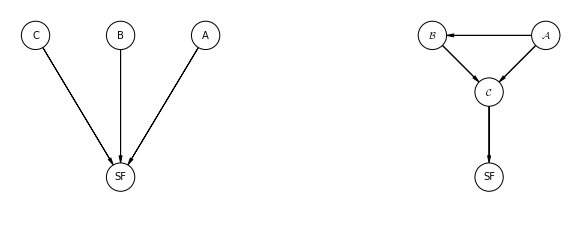

In [100]:
pgm = daft.PGM([10, 4], origin=[.5,.5])
pgm.add_node(daft.Node("A", r"A", 4.0, 4.0))
pgm.add_node(daft.Node("B", r"B", 2.5, 4.0))
pgm.add_node(daft.Node("C", r"C", 1.0, 4.0))
pgm.add_node(daft.Node("outcome", r"SF", 2.5, 1.5))

pgm.add_edge("A", "outcome")
pgm.add_edge("B", "outcome")
pgm.add_edge("C", "outcome")

pgm.add_node(daft.Node("Acal", r"$\mathcal{A}$", 10.0, 4.0))
pgm.add_node(daft.Node("Bcal", r"$\mathcal{B}$", 8.0, 4.0))
pgm.add_node(daft.Node("Ccal", r"$\mathcal{C}$", 9.0, 3.0))
pgm.add_node(daft.Node("outcomeCal", r"SF", 9.0, 1.5))

pgm.add_edge("Acal", "Ccal")
pgm.add_edge("Acal", "Bcal")
pgm.add_edge("Bcal", "Ccal")
pgm.add_edge("Ccal", "outcomeCal")

pgm.render()

We often need to consider when factors are not independent. See right diagram above: $\mathcal{A}$ affects $\mathcal{B}$ and $\mathcal{C}$, $\mathcal{B}$ affects $\mathcal{C}$.

For general case we have:
$$ P(\mathcal{A},\mathcal{B}, \mathcal{C}) = P(\mathcal{A} \mid \mathcal{B}, \mathcal{C}) P(\mathcal{B} \mid \mathcal{C}) P(\mathcal{C}) $$
Bayesian Network (BN) is a systematic approach to investigate 'causalties' of factors, using Probability Graphical Model (PGM).

In this write up, we contemplate applicability of BN (PGM) in trading.

#### Example [Bayesian Network]

We refer to Wikipedia article for the definition of BN: 'https://en.wikipedia.org/wiki/Bayesian_network#Example'

We adopt famous 'Rain-Sprinkler-Grass Wet' (RSG) example for our situation.

In [101]:
from IPython.display import Image
Image(url='http://upload.wikimedia.org/wikipedia/commons/0/0e/SimpleBayesNet.svg')

Let 'cheapOil' denote market where oil price is below 70 dollars. We assume there is 20% chance this may happen:
$$ P(cheapOil) = 0.2 \ \ P(\neg cheapOil) = 0.8 $$
Let 'teslaUp' denote market where Tesla stock goes up.  We assume following conditional probabilities:
$$ P(teslaUp \mid cheapOil) = 0.01\ \ P(teslaUp \mid \neg cheapOil) = 0.4 $$
$$ P(\neg teslaUp \mid cheapOil) = 0.99\ \ P(\neg teslaUp \mid \neg cheapOil) = 0.6 $$

Next let 'hitachiUp' denote market where Hitachi battery stock goes up. Similarly we assume:
$$ P (hitachiUp \mid teslaUp, cheapOil) = 0.99 \ \ P (\neg hitachiUp \mid teslaUp, cheapOil) = 0.01 $$
and so on (we are following table above with cheapOil=Rain, teslaUp=Sprinkler, hitachiUp=Grass Wet).

Suppose we want to know $P(cheapOil \mid hitachiUp)$: given Hitachi goes up, what is the probability of oil is under 70?  

This can be manually calculated as shown in wikipedia: approximately 0.3577

Note that this calculation is slightly more complicated than before, since we are not assuming independence (left diagram below).  Or if we were in situation when we only need to monitor Tesla stock to know how Hitachi stock behaves, things would have been simpler (right diagram below). Still, this example is simple enough with three nodes and 3 edges in PGM to compute manually.

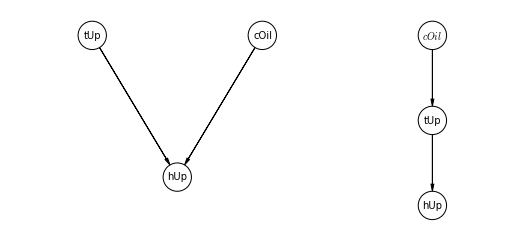

In [110]:
pgm = daft.PGM([9, 4], origin=[.5,.5])
pgm.add_node(daft.Node("cO", r"cOil", 5.0, 4.0))
pgm.add_node(daft.Node("tUp", r"tUp", 2.0, 4.0))
pgm.add_node(daft.Node("hUp", r"hUp", 3.5, 1.5))

pgm.add_edge("cO", "hUp")
pgm.add_edge("tUp", "hUp")

pgm.add_node(daft.Node("cO1", r"$cOil$", 8.0, 4.0))
pgm.add_node(daft.Node("tUp1", r"tUp", 8.0, 2.5))
pgm.add_node(daft.Node("hUp1", r"hUp", 8.0, 1.0))

pgm.add_edge("cO1", "tUp1")
pgm.add_edge("tUp1", "hUp1")
pgm.render()

In general, we want to have many more nodes and edges in PGM: many factors affecting others in various ways.
(We allow only Directed Acyclic Graph fpr PGM). 

For more genral PGM, we want to use simulation tools to estimate probabilities involved. MCMC is one of those tools.

#### Example [Simple MCMC]

SY Note: It took me for a while to figure out pyMC grammar. It is a popular library but documentation is sparse. I will put more comments when I become more comfortable with its black box inner workings.

We start with Bernoulli distribution for cheapOil, teslaUp, hitachiUp.  Recall that if we keep flipping a fair coin, its head-tail tally follows Bernoulli distribution with probability $p=0.5$ 

We use $p=0.2$ for cheapOil and conditional probabilty (functions) for teslaUp and hitachiUp.

In [46]:
# initialization
observed_hitachi = [1.]

cheapOil = pm.Bernoulli('cheapOil', .2, value=np.ones(len(observed_hitachi)))

p_teslaUp = pm.Lambda('p_teslaUp', lambda cheapOil=cheapOil: np.where(cheapOil, .01, .4))

'''
@pm.deterministic
def p_teslaUp (cheapOil=cheapOil):
    if cheapOil:
        return 0.01
    else:
        return 0.4
'''

teslaUp = pm.Bernoulli('teslaUp', p_teslaUp, value=np.ones(len(observed_hitachi)))

p_hitachiUp = pm.Lambda('p_hitachiUp', lambda teslaUp=teslaUp, cheapOil=cheapOil: np.where(teslaUp, np.where(cheapOil, 1.0, .9), 
                                                                                        np.where(cheapOil, .8, 0.2)))
'''
@pm.deterministic
def p_hitachiUp (teslaUp=teslaUp, cheapOil=cheapOil):
    if teslaUp:
        if cheapOil:
            return 0.99
        else:
            return 0.9
    else:
        if cheapOil:
            return 0.8
        else:
            return 0.0
'''                                                                                  
hitachiUp = pm.Bernoulli('hitachiUp', p_hitachiUp, value=observed_hitachi, observed=True)

model = pm.Model([hitachiUp, p_hitachiUp, teslaUp, p_teslaUp, cheapOil])

mcmc = pm.MCMC(model)
mcmc.sample(10000, 2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.5 sec

Next we make a table:

In [47]:
cheap_oil_trace = mcmc.trace('cheapOil')[:]
p_tesla_up_trace = mcmc.trace('p_teslaUp')[:]
tesla_up_trace = mcmc.trace('teslaUp')[:]
p_hitachi_up_trace = mcmc.trace('p_hitachiUp')[:]

# this does not work, why??
#hitachi_up_trace = mcmc.trace('hitachiUp')[:]

dictionary = {
              'Cheap Oil': [1 if ii[0] else 0 for ii in cheap_oil_trace.tolist() ],
              'Tesla Up': [1 if ii[0] else 0 for ii in tesla_up_trace.tolist() ],
              'Tesla Up Prob': [ii[0] for ii in p_tesla_up_trace.tolist()],
              'Hitachi Up': [ii[0] for ii in p_hitachi_up_trace.tolist()], # Hitachi Up Prob
              }
df = pd.DataFrame(dictionary)
df[:12]


,Cheap Oil,Hitachi Up,Tesla Up,Tesla Up Prob
0,1,0.8,0,0.01
1,1,0.8,0,0.01
2,1,0.8,0,0.01
3,1,0.8,0,0.01
4,1,0.8,0,0.01
5,1,0.8,0,0.01
6,1,0.8,0,0.01
7,0,0.2,0,0.40
8,0,0.9,1,0.40
9,0,0.9,1,0.40


We knew by hand calculation
$$ P(cheapOil \mid hitachiUp) = \frac{P(cheapOil, hitachiUp)}{P(hitachiUp)} \approx 0.3577 $$
Now we estimate this from the simulation:

In [48]:
tally_cheapOil_and_hitachiUp = df[(df['Cheap Oil'] == 1) & (df['Hitachi Up'] > 0.5)].shape[0]
tally_hitachiUp = df[df['Hitachi Up'] > 0.5].shape[0]

print 'MCMC estimation:', float(tally_cheapOil_and_hitachiUp)/tally_hitachiUp


MCMC estimation: 0.35809896225
